In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from typing import Any
import logging
from tqdm import tqdm

# PyTorch and Lightning
import lightning as pl
import torch
from torch.utils.data import DataLoader, Subset

# Transformers (BERT)
from transformers import BertModel, DataCollatorForTokenClassification

# Calvera bandit library
from calvera.bandits import NeuralLinearBandit
from calvera.benchmark.datasets import ImdbMovieReviews
from calvera.benchmark import BanditBenchmarkEnvironment, BertWrapper
from calvera.utils import ListDataBuffer, AllDataBufferStrategy

In [2]:
def transformers_collate(batch: Any, data_collator: DataCollatorForTokenClassification) -> Any:
    """Custom collate function for processing transformer inputs in the DataLoader.

    Args:
        batch: The batch to collate.
        data_collator: The data collator to use.

    Returns:
        The collated batch with properly formatted transformer inputs.
    """
    examples = []
    for item in batch:
        inputs = item[0]
        example = {
            "input_ids": inputs[0],
            "attention_mask": inputs[1],
            "token_type_ids": inputs[2],
        }
        examples.append(example)

    # Let the data collator process the list of individual examples.
    context = data_collator(examples)
    input_ids = context["input_ids"]
    attention_mask = context["attention_mask"]
    token_type_ids = context["token_type_ids"]

    if len(batch[0]) == 2:
        realized_rewards = torch.stack([item[1] for item in batch])
        return (input_ids, attention_mask, token_type_ids), realized_rewards

    embedded_actions = None if batch[0][1] is None else torch.stack([item[1] for item in batch])
    realized_rewards = torch.stack([item[2] for item in batch])
    chosen_actions = None if batch[0][3] is None else torch.stack([item[3] for item in batch])

    return (input_ids, attention_mask, token_type_ids), embedded_actions, realized_rewards, chosen_actions

In [3]:
# Load the IMDB Movie Reviews dataset
dataset = ImdbMovieReviews()

# Print dataset information
print(f"Dataset context size: {dataset.context_size}")
print(f"Dataset sample count: {len(dataset)}")

Dataset context size: 256
Dataset sample count: 24904


In [4]:
# Configuration
EMBEDDING_SIZE = 128
BUFFER_SIZE = 1024
NUM_ARMS = 2
NUM_SAMPLES = 10000
BATCH_SIZE = 32

# Create data loader for a subset of the data
collate_fn = partial(transformers_collate, data_collator=dataset.get_data_collator())
train_loader = DataLoader(
    Subset(dataset, range(NUM_SAMPLES)), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)

# Set up the environment
accelerator = "cpu"
env = BanditBenchmarkEnvironment(train_loader, device=accelerator)

# Create BERT model (using a small version for demonstration)
network = BertWrapper(BertModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2", output_hidden_states=True).eval())

# Create memory buffer to store experiences
buffer = ListDataBuffer(
    buffer_strategy=AllDataBufferStrategy(),
    max_size=BUFFER_SIZE,
)

# Initialize the NeuralLinearBandit module with BERT
bandit_module = NeuralLinearBandit(
    network=network,
    buffer=buffer,
    n_embedding_size=EMBEDDING_SIZE,
    contextualization_after_network=True,  # Important for handling text embeddings
    n_arms=NUM_ARMS,
    initial_train_steps=128,
    min_samples_required_for_training=128,
)

# Configure logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)

In [5]:
# Initialize arrays to store metrics
rewards = np.array([])
regrets = np.array([])

# Training loop with progress bar
progress = tqdm(iter(env), total=len(env), desc="Training Neural Linear BERT bandit")

for contextualized_actions in progress:
    # 1. Select actions based on current model
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    # 2. Create a trainer for this step
    trainer = pl.Trainer(
        max_epochs=1,
        enable_progress_bar=False,
        enable_model_summary=False,
        log_every_n_steps=1,
        accelerator=accelerator,
    )

    # 3. Get feedback from environment
    chosen_contextualized_actions, realized_rewards = env.get_feedback(chosen_actions)
    batch_regret = env.compute_regret(chosen_actions)

    # 4. Track metrics
    rewards = np.append(rewards, realized_rewards.cpu().numpy())
    regrets = np.append(regrets, batch_regret.cpu().numpy())

    # Update progress bar with current metrics
    progress.set_postfix(
        {"reward": realized_rewards.mean().item(), "regret": batch_regret.mean().item(), "avg_regret": regrets.mean()}
    )

    # 5. Update the bandit with feedback
    bandit_module.record_feedback(chosen_contextualized_actions, realized_rewards, chosen_actions)
    trainer.fit(bandit_module)
    bandit_module = bandit_module.to(accelerator)

# Store metrics in a DataFrame
metrics = pd.DataFrame(
    {
        "reward": rewards,
        "regret": regrets,
    }
)

# Display the first few rows of metrics
metrics.head()

Training Neural Linear BERT bandit: 100%|██████████| 313/313 [11:42<00:00,  2.24s/it, reward=1, regret=0, avg_regret=0.0024]        


,reward,regret
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0


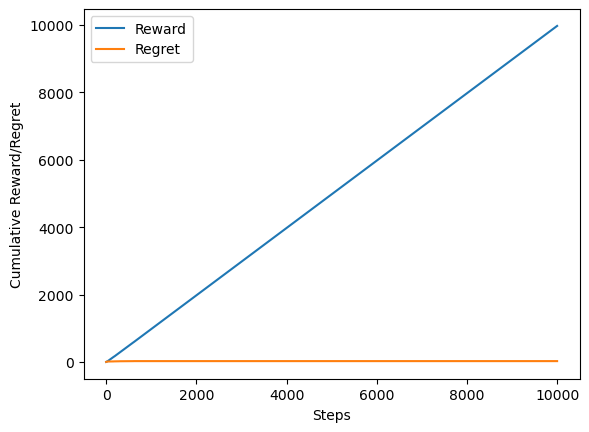

In [6]:
# Calculate cumulative metrics
cumulative_reward = np.cumsum(metrics["reward"])
cumulative_regret = np.cumsum(metrics["regret"])

# Plot cumulative regret and reward
plt.plot(cumulative_reward, label="Reward")
plt.plot(cumulative_regret, label="Regret")
plt.xlabel("Steps")
plt.ylabel("Cumulative Reward/Regret")
plt.legend()
plt.show()

In [7]:
# Calculate metrics for each time horizon
print(f"Average reward (first 10 rounds): {np.mean(metrics['reward'][:10]):.4f}")
print(f"Average reward (first 100 rounds): {np.mean(metrics['reward'][:100]):.4f}")
print(f"Average reward (all rounds): {np.mean(metrics['reward']):.4f}")
print("")
print(f"Average regret (first 10 rounds): {np.mean(metrics['regret'][:10]):.4f}")
print(f"Average regret (first 100 rounds): {np.mean(metrics['regret'][:100]):.4f}")
print(f"Average regret (all rounds): {np.mean(metrics['regret']):.4f}")

Average reward (first 10 rounds): 0.6000
Average reward (first 100 rounds): 0.8800
Average reward (all rounds): 0.9976

Average regret (first 10 rounds): 0.4000
Average regret (first 100 rounds): 0.1200
Average regret (all rounds): 0.0024
